In [1]:
import pandas as pd
from myfunc import force_pos, Disparity, commu_detect, commu_detect_weighted, curve_edges
from matplotlib import rcParams
from matplotlib import pyplot as plt
import networkx as nx
import re
from collections import Counter
import random
import math
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text
from adjustText import adjust_text
from networkx.algorithms.community import modularity
from collections import defaultdict
import matplotlib.transforms
from matplotlib.collections import LineCollection

**Network analysis**

In [3]:
#get doi
data=pd.read_csv('data_10_20.csv')
for m in range(len(data)):
    ls=[]
    try:
        for i in data.References[m].strip().split('; '):
            for j in i.split(','):
                if 'DOI' in j:
                    ls.append(j.replace('DOI','').replace('[','').replace(']','').lower().strip())
        data.loc[m,'cites_doi']='; '.join([i for i in set(ls)])
    except:
        data.loc[m,'cites_doi']=np.nan

In [233]:
# set ISSNs to indexes 
journals=[i for i in data.ISSN.str.lower().unique()]
np_journals=np.array(journals).reshape(-1,1)
index_ISSN=dict(enumerate(np_journals[:,0])) 
ISSN_index=dict((j,i) for i,j in enumerate(np_journals[:,0]))

# extract direct citation relations from WoS
cite=data[['Title','DOI','Year','cites_doi']]
edges=[]
for i in range(len(cite)):
    try:
        a=cite.cites_doi[i].strip().split('; ')
        for k in range(len(a)):
            if a[k] not in 'nan':    
                edges.append((cite.DOI[i].lower(),a[k]))
    except:
        pass

In [234]:
# within dataset citation wos
citess=pd.DataFrame()
citess['DOI']=[i[1] for i in edges]
citess['citing']=[i[0] for i in edges]
cite.columns=['Title', 'citing', 'Year', 'cites_doi'] 
citess=citess.merge(cite,on=['citing'],how='left')
within=citess[citess['DOI'].isin(data['DOI'])].reset_index(drop=True)

In [235]:
# get the ISSN for both cited and citing papers 
data.ISSN=data.ISSN.str.lower()
w=within.merge(data[['DOI', 'ISSN']],on=['DOI']) # cited 
w.columns=['cited_DOI', 'DOI', 'Title', 'Year', 'reference_doilist', 'cited_ISSN']
w=w.merge(data[['DOI', 'ISSN']],on=['DOI']) # citing 
w.columns=['cited_DOI', 'citing_DOI', 'Title', 'Year', 'reference_doilist', 'cited_ISSN',
      'citing_ISSN']

In [236]:
# Create journal citation links
journal_ci=[(i,j) for i,j in w[['cited_ISSN', 'citing_ISSN']].to_numpy()]
jc_df=pd.DataFrame(journal_ci, columns=['citing','cited']) 
jc_df['citing_ind']=[ISSN_index[str(i)] for i in jc_df.citing.to_list()] #get index 
jc_df['cited_ind']=[ISSN_index[str(i)] for i in jc_df.cited.to_list()]
def df_to_list(df):
    return [(int(df.iloc[i].to_list()[0]),int(df.iloc[i].to_list()[1])) for i in range(len(df))]
links=df_to_list(jc_df[['citing_ind','cited_ind']])

In [238]:
# weighted network 
count=dict(Counter(links))
edges=[(i+(count[i],)) for i in count]
G=nx.Graph()
G.add_weighted_edges_from(edges)
# number of journals in the network
G.number_of_nodes()

1780

In [239]:
# some network quantities
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)           
def f_gcc(G):                   # fraction of nodes in GCC
    GCC = max(connected_component_subgraphs(G),key=len)
    return GCC.number_of_nodes()/G.number_of_nodes()
def a_d(G):
    return sum([d for (n, d) in nx.degree(G)]) / float(G.number_of_nodes())

def acc(G):
  nodes = [n for n in G.nodes() if G.degree(n) >1]
  clustering = nx.clustering(G, nodes)
  return sum(clustering.values())/len(clustering)

In [241]:
# disparity filter on the network 
G1=Disparity(G, 0.5)
#G2=Disparity(G, 0.3)
GCC=max(connected_component_subgraphs(G1),key=len)
print(G1.number_of_nodes(), "nodes, fraction", np.round(G1.number_of_nodes()/G.number_of_nodes(), 6))
print(G1.number_of_edges(), "edges, fraction", np.round(G1.number_of_edges()/G.number_of_edges(), 3))
print("acc", acc(G1))
print("ad", a_d(G1))
print("GCC", GCC.number_of_nodes(),GCC.number_of_nodes()/G1.number_of_nodes())

1552 nodes, fraction 0.87191
9530 edges, fraction 0.843
acc 0.3339597539778246
ad 12.280927835051546
GCC 1547 0.9967783505154639


In [244]:
#community detection with infomap 
(n, m),G=commu_detect(G)
def modularity_compute(G, communities):
    v = defaultdict(list)
    for key, value in sorted(dict(communities).items()):
        v[value].append(key)
    return modularity(G, v.values())
modularity_compute(GCC, communities)

0.5067272256974146

In [25]:
# layout foceatlas
pos=force_pos(GCC, adjustSizes=True)

100%|██████████| 1000/1000 [00:14<00:00, 70.19it/s]

BarnesHut Approximation  took  5.57  seconds
Repulsion forces  took  7.97  seconds
Gravitational forces  took  0.05  seconds
Attraction forces  took  0.12  seconds
AdjustSpeedAndApplyForces step  took  0.25  seconds


/home/unicph.domain/mgd405/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


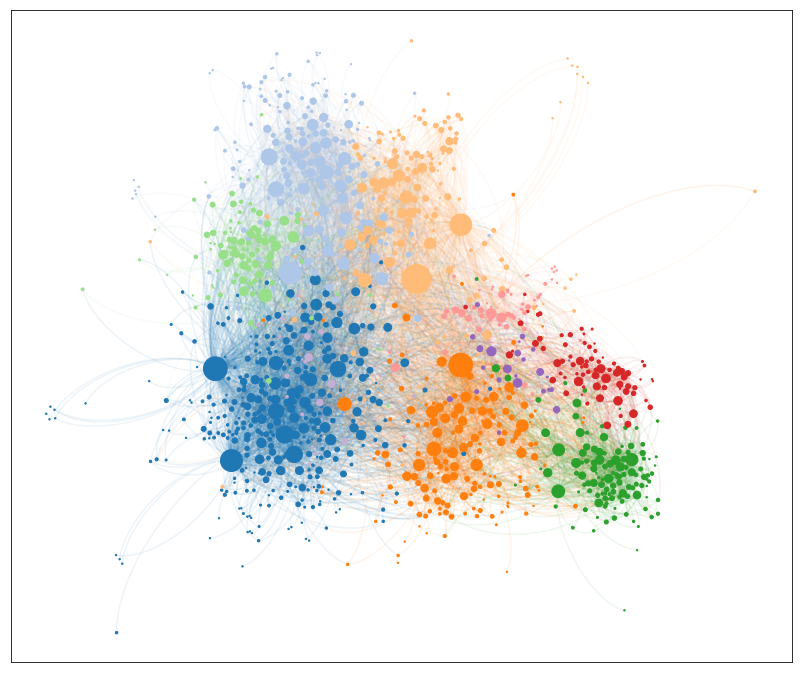

In [28]:
plt.figure(figsize=(14,12))
values = [GCC.nodes[node]['community'] for node,j in GCC.nodes(data=True)]
colors = np.array(sns.color_palette("tab20", len(set(values))))
curves = curved_edges(GCC,selected_edges, pos)
lc = LineCollection(curves, colors=edge_colors, alpha=0.08)
plt.gca().add_collection(lc)
selected_nodes=[]
node_color={}
for i in range(1,11):
    node_list=[]
    for node,j in GCC.nodes(data=True):
        if GCC.nodes[node]['community'] ==i:
            node_list.append(node)
            selected_nodes.append(node)
            node_color[node]=colors[i-1]
    nodes=nx.draw_networkx_nodes(node_list,pos,node_color = colors[i-1].reshape(1,-1),node_size=[v*2 for i,v in dict(GCC.degree()).items() if i in node_list])
plt.show()


**Method distribution**

In [247]:
# create a dataframe for the network property 
cate=pd.DataFrame()
cate['ISSN']=[index_ISSN[i] for i in G.nodes()]
cate['Node_Index']=[i for i in G.nodes()]
cate['Community']=["Cluster " +str(GCC.nodes[i]['community'])if i in GCC.nodes() else np.nan  for i,j in G.nodes(data=True)]
cate=cate.merge(data[['ISSN','Journal','keywords']].drop_duplicates(subset=['ISSN']), on=['ISSN'])
cate_method=cate.merge(data[['ISSN','Method_detect']], on=['ISSN'] )
#cate_method.to_csv('cate_method.csv', index=False)

In [2]:
cate_method=pd.read_csv('cate_method.csv')

In [6]:
# journals in Cluter 1
cate_method[cate_method.Community=='Cluster 1'].groupby('Journal').count().sort_values('ISSN',ascending=False)[:10]

,ISSN,Community,keywords,Method_detect
Journal,,,,
COMPUTERS IN HUMAN BEHAVIOR,253,253,253,253
NEW MEDIA & SOCIETY,132,132,132,132
SOCIAL MEDIA + SOCIETY,112,112,112,112
INFORMATION COMMUNICATION & SOCIETY,111,111,111,111
PUBLIC RELATIONS REVIEW,67,67,67,67
ONLINE INFORMATION REVIEW,67,67,67,67
SOCIAL SCIENCE COMPUTER REVIEW,41,41,41,41
JOURNAL OF COMPUTER-MEDIATED COMMUNICATION,41,41,41,41
DISCOURSE CONTEXT & MEDIA,38,38,38,38


In [41]:
# OECD field
index_ds={'2': 'engineering and technology','1':'natural sciences', '5':'social sciences', '3':'medical and health sciences','6':'humanities', '4':'agricultural sciences'}
# methods detected in journals 
data2=cate_method[cate_method.Method_detect.str.len() !=2].reset_index(drop=True)
data2['Method_detect']=data2.Method_detect.apply(lambda x:eval(x))
data3=data2.explode('Method_detect').reset_index(drop=True)
data3['field']=data3.keywords.apply(lambda x:index_ds[str(x)])

In [42]:
# the most common ten methods detected 
bg=data3.dropna(subset=['Community']).groupby('Method_detect').count().sort_values(by='Journal',ascending=False)[:10].index.to_list()
cate_=data3[data3.Method_detect.isin(bg) & data3.Community.isin(["Cluster "+str(i) for i in range(1,9)]) ]
cate_=cate_.drop_duplicates()

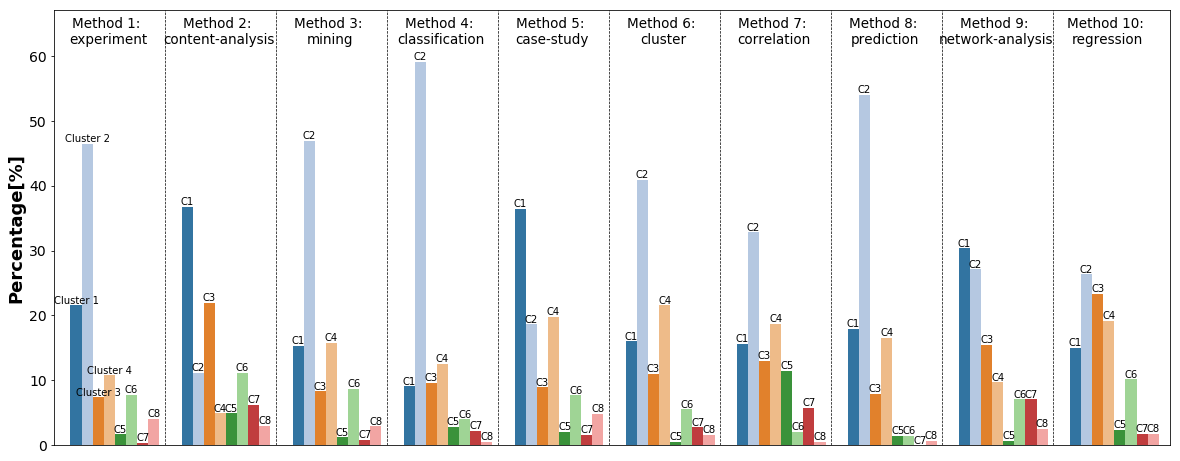

In [55]:
#plot method distribution normalized per method
x, y="Method_detect", "Community"
colors = np.array(sns.color_palette("tab20", 8))
df_1=cate_.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index()
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(20,8) ) 
ax=sns.barplot(x,y='percent',hue=y, data=df_1, hue_order=["Cluster "+str(i) for i in range(1,9)], order=bg, palette=colors)
ax.set_xlabel('', fontsize=18,fontweight='bold')
ax.legend('',loc='upper right', fontsize=18)
ax.set_ylabel('Percentage[%]', fontsize=18,fontweight='bold')
ax.set_xticklabels(['Method '+str(i+1)+': \n' + n for i,n in enumerate(bg)], size = 13.5)
offset = matplotlib.transforms.ScaledTranslation(-7/72., 6.05, fig.dpi_scale_trans)
for i, label in enumerate(ax.xaxis.get_majorticklabels()):
    label.set_transform(label.get_transform() + offset)
ax.set_yticklabels([int(i) for i in ax.get_yticks()], size = 14)
[ax.axvline(0.45+i, linestyle='--', color='black', linewidth=0.7) for i in range(9)]
ax.tick_params(bottom=False)
names=["Cluster " + str(i) for i in range(1,5)] +["C" + str(i) for i in range(5,9)]
names_1=["C" + str(i) for i in range(1,9)]
names_2=[]
for i in range(8):
    a=0
    names_2.append(names[i])
    while a<9:
        names_2.append(names_1[i])
        a+=1
plt.xlim(-0.55,)
texts=[]
for i,p in enumerate(ax.patches):
    ax.annotate(names_2[i], (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

ax.annotate("C7", (7.25,-0.05), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')    
plt.ylim(0,67)
ax.get_legend().remove()
plt.show()

#fig.savefig("methods_distribution1.png")

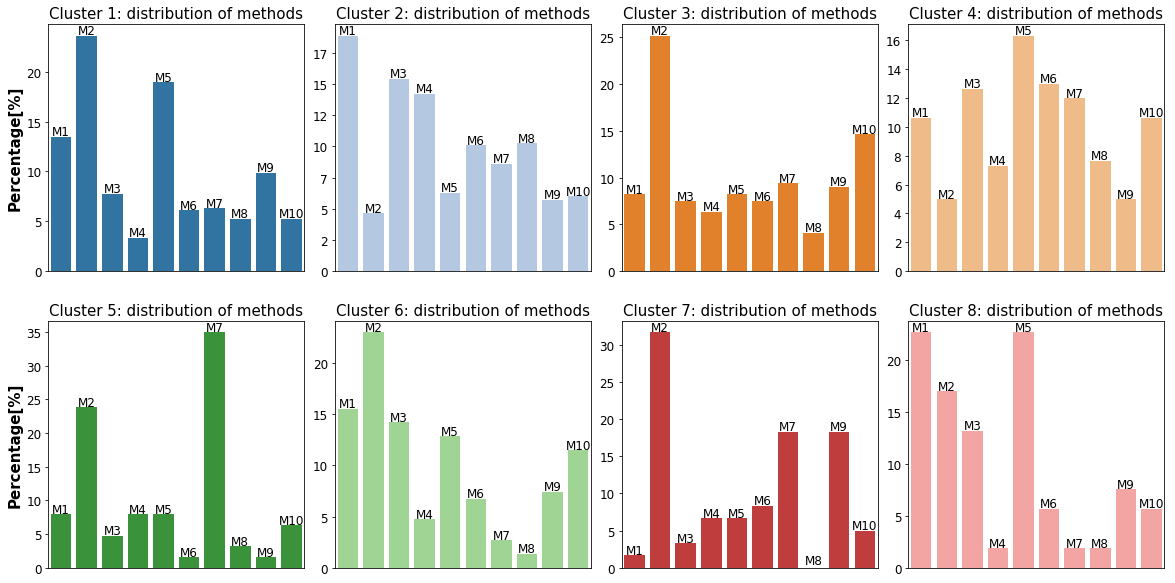

In [121]:
# normalize per cluster 
fig, axes = plt.subplots(2, 4, figsize=(20,10))
df_1=cate_.groupby(y)[x].value_counts(normalize=True).mul(100).rename('percent').reset_index()
a=0
for n in axes:
    for j in n:
        a+=1
        sns.barplot(x,y='percent', data=df_1[df_1.Community=="Cluster " +str(a)], order=bg, color=colors[a-1], ax=j)
        j.set_title('Cluster '+str(a) +": distribution of methods", fontdict = {'size':15})
        j.set_xlabel('', fontsize=13,fontweight='bold')
        j.set_xticklabels("")
        j.tick_params(bottom=False)
        j.set_yticklabels([int(i) for i in j.get_yticks()], size = 12)
        j.set_ylabel('', fontsize=13,fontweight='bold')
        if a in [1, 5]:
            j.set_ylabel('Percentage[%]', fontsize=15,fontweight='bold')
        methods_list=["M"+ str(i) for i in range(1,11)]
        for i,p in enumerate(j.patches):  
            if a==7 and i==7:
                j.annotate(methods_list[i], (j.patches[6].get_x() + j.patches[6].get_width() / 2+1, -0.05), ha = 'center', va = 'center', xytext = (0, 8), fontsize=12, textcoords = 'offset points')
            else:
                j.annotate(methods_list[i], (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), fontsize=12,textcoords = 'offset points')
            
plt.subplots_adjust(wspace = 0.12)
plt.show()
#fig.savefig("methods_distribution2.png")

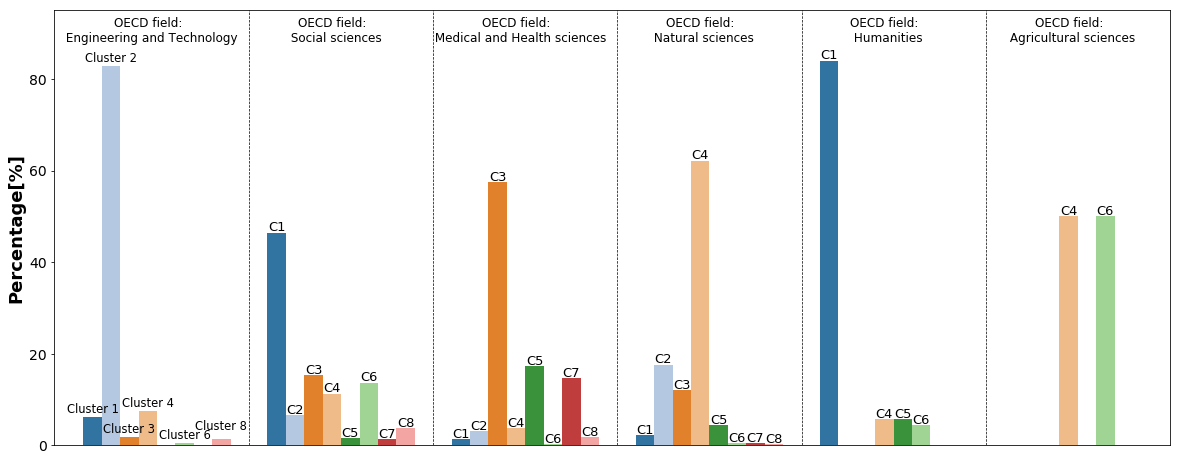

In [28]:
# distribution of OECD fields across clusters
bg=data3.dropna(subset=['Community']).groupby('field').count().sort_values(by='Journal',ascending=False).index.to_list()
cate_=data3[data3.field.isin(bg) & data3.Community.isin(["Cluster "+str(i) for i in range(1,9)]) ].drop_duplicates()
x, y="field", "Community"
df_2=cate_.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index()
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(20,8) ) 
ax=sns.barplot(x,y='percent',hue=y, data=df_2, hue_order=["Cluster "+str(i) for i in range(1,9)],order=bg, palette=colors)
ax.set_xlabel('', fontsize=18,fontweight='bold')
ax.legend('',loc='upper right', fontsize=18)
ax.set_ylabel('Percentage[%]', fontsize=18,fontweight='bold')
ax.set_xticklabels(['OECD field'+': \n ' + i for i in ['Engineering and Technology','Social sciences', 'Medical and Health sciences',  'Natural sciences', 'Humanities', 'Agricultural sciences']],  size = 12)
offset = matplotlib.transforms.ScaledTranslation(-7/72., 6.05, fig.dpi_scale_trans)
for i, label in enumerate(ax.xaxis.get_majorticklabels()):
    label.set_transform(label.get_transform() + offset)
ax.set_yticklabels([int(i) for i in ax.get_yticks()], size = 14)
[ax.axvline(0.5+i, linestyle='--', color='black', linewidth=0.7) for i in range(5)]
ax.tick_params(bottom=False)
names=["Cluster " + str(i) for i in range(1,9)] 
names_1=["C" + str(i) for i in range(1,9)]
names_2=[]
for i in range(8):
    a=0
    names_2.append(names[i])
    while a<5:
        names_2.append(names_1[i])
        a+=1
plt.xlim(-0.56,)
for i,p in enumerate(ax.patches):
    if i%6==0:
        if i== 42:
            ax.annotate(names_2[i], (p.get_x() + p.get_width() / 2, p.get_height()+1), ha = 'center', va = 'center', xytext = (0, 8.5), fontsize=11.5, textcoords = 'offset points')
        else:
            ax.annotate(names_2[i], (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center', va = 'center', xytext = (0, 8), fontsize=11.5, textcoords = 'offset points')
    else:
      ax.annotate(names_2[i], (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center', va = 'center', xytext = (0, 5),fontsize=13, textcoords = 'offset points')
plt.ylim(0,95)
ax.get_legend().remove()
ax.set_yticklabels([int(i) for i in ax.get_yticks()], size = 14)
plt.show()
#fig.savefig("field_distribution1.png")

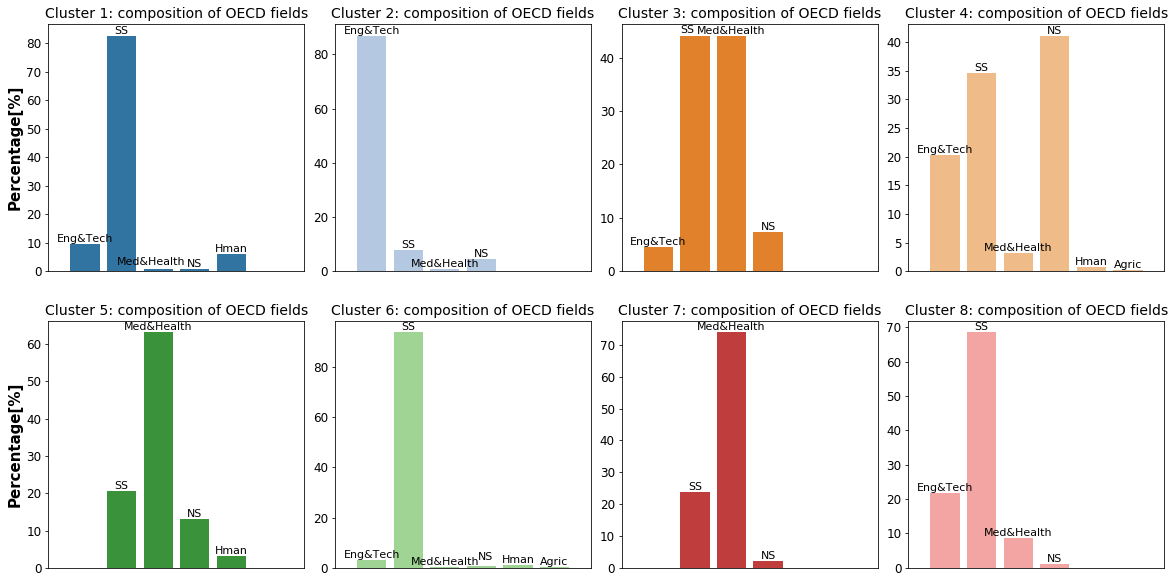

In [36]:
df_2=cate_.groupby(y)[x].value_counts(normalize=True).mul(100).rename('percent').reset_index()
fig, axes = plt.subplots(2, 4, figsize=(20,10))
a=0
for n in axes:
    for j in n:
        a+=1
        sns.barplot(x,y='percent', data=df_2[df_2.Community=="Cluster " +str(a)], order=bg, color=colors[a-1], ax=j)
        j.set_title('Cluster '+str(a) +": composition of OECD fields", fontdict = {'size':14})
        j.set_xlabel('', fontsize=13,fontweight='bold')
        j.set_xticklabels("")
        j.tick_params(bottom=False)
        j.set_yticklabels([int(i) for i in j.get_yticks()], size = 12)
        j.set_ylabel('', fontsize=13,fontweight='bold')
        if a in [1, 5]:
            j.set_ylabel('Percentage[%]', fontsize=15,fontweight='bold')
        methods_list=['Eng&Tech','SS','Med&Health','NS', "Hman", 'Agric']
        if a==3:
            for i,p in enumerate(j.patches):  
                if i==1:
                    j.annotate(methods_list[i], (p.get_x() + p.get_width() / 2-0.2, p.get_height()), ha = 'center', va = 'center', xytext = (0, 6), fontsize=11,textcoords = 'offset points')
                else:
                    j.annotate(methods_list[i], (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), fontsize=11,textcoords = 'offset points')
        else:
            for i,p in enumerate(j.patches):  
                j.annotate(methods_list[i], (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), fontsize=11,textcoords = 'offset points')
        j.set_xlim(-1, 6)
plt.subplots_adjust(wspace = 0.12)

plt.show()
#fig.savefig("field_distribution2.png")

**Null model**

In [ ]:
null_dataset=data3[data3.Method_detect.isin(bg)].reset_index(drop=True)
null_dataset['Community']=null_dataset['Community'].replace('nan', np.nan)
null=null_dataset.dropna(subset=['Community'])
for i in range(1000):
  commu=null.Method_detect.to_list()
  random.shuffle(commu)
  null['Shuffle_commu'+str(i)]=commu

In [34]:
# z test and p value
import scipy
def check(n):
  dis=null[null.Community=="Cluster "+str(n)].Method_detect.unique()
  for i in dis:
    observed=null[null['Community'].isin(["Cluster "+str(n)])&null.Method_detect.isin([str(i)])].Method_detect.count()
    allc=[]
    for k in range(1000):
      allc.append(null[null['Shuffle_commu'+str(k)].isin([str(i)])&null.Community.isin(["Cluster "+str(n)])].Method_detect.count())
    z=(observed-np.mean(allc))/np.std(allc)
    p=scipy.stats.norm.sf(abs(z))*2
    if z>0 and p<0.01:
      print("Method ", i)
      print("z score is", z, "p value is",p)

In [37]:
check(4)

Method  prediction
z score is 3.5866220430638425 p value is 0.00033498931820423456
Method  cluster
z score is 5.982356403180486 p value is 2.199323786585488e-09
Method  correlation
z score is 4.35891227267067 p value is 1.3071049332665647e-05
Method  regression
z score is 4.263551747564322 p value is 2.0120287733759613e-05
Method  case-study
z score is 7.470251814040799 p value is 8.004150046638108e-14
